# Strategy backtester

This notebook explains the backtester that is used to evaluate the performance of a given strategy over historic data. This is done by loading the historic data and replaying it as if it were live and repeatedly prompting the strategy for actions (buy, sell, do nothing, etc.).

A strategy is an implementation that takes the dataset as input and outputs actions. In this notebook, we will consider a simple strategy based on the output of the SCINet model. The exact strategy will be explained later.

In [1]:
import os
import sys

cwd = os.getcwd()
BASE_DIR = os.path.dirname(os.path.dirname(cwd))

sys.path.insert(0, BASE_DIR) #add base to path for relative imports

sys.path.insert(0, "data/")

In [2]:
from tqdm import tqdm
import numpy as np
import matplotlib.dates as md
import datetime as dt

from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
#utilities used by the backtester to simulate performance
from utils.data_handler import HistoricCSVDataHandler #dataset loader
from utils.portfolio import Portfolio #track balances, equity, etc.
from utils.sim_execution_engine import ExecutionEngine, SimulatedExecutionEngine #order execution simulation
from utils.strategy import Strategy #strategy baseclass

In [4]:
from strategies.scinet_strategy import SCINET_Strategy #strategy based on SCINet output

The class below defines the entire backtester that is used to simulate the performance of the SCINET_Strategy on a dataset. 

It first loads the data, then iterates through it entirely, prompting the strategy at each iteration. As the strategy outputs actions the performance and balances are tracked in the Portfolio class. At the end of the backtest the historic performance is plotted.

In [5]:
class Backtest:
    """
    Contains the settings and components for carrying out
    an event-driven backtest.
    """

    def __init__(   self,
                    data_handler: HistoricCSVDataHandler,
                    execution_engine: ExecutionEngine,
                    portfolio: Portfolio, 
                    strategy: Strategy,
                    START: int,
                    STOP: int,
                    STEP: int,
                    ) -> None:
        """
        Initialize backtest.
        Parameters:
        -= data_handler: HistoricCSVDataHandler class
        -= execution_engine: ExecutionEngine class
        -= portfolio: Portfolio class
        -= strategy: Strategy class
        """
        
        self.data_handler = data_handler
        self.execution_engine = execution_engine
        self.portfolio = portfolio
        self.strategy = strategy

        self.n_signals = 0
        self.n_orders = 0
        self.n_fills = 0

        self.START = START
        self.STOP = STOP
        self.STEP = STEP


    def run(self):
        """
        Execute the backtest.
        """

        print(f"Starting backtest @ {datetime.utcnow()} UTC")



        for i in tqdm(range(self.START, self.STOP, self.STEP)):
            latest_bar_data = self.data_handler.symbol_data.copy()
    
            for symbol in latest_bar_data:
                latest_bar_data[symbol] = latest_bar_data[symbol].iloc[self.START:i + 1, :]
            
        
            signal_event = self.strategy.calculate_signals(latest_bar_data)
            if signal_event != None:
                # print(signal_event)
                self.n_signals += 1

                order_event = self.portfolio.request_order(signal_event, latest_bar_data)
                
                if order_event != None:
                    # print(order_event)
                    self.n_orders += 1

                    fill_event = self.execution_engine.execute_order(order_event)
                    
                    if fill_event != None:
                        # print(fill_event)
                        self.n_fills += 1

                        self.portfolio.update_fill(fill_event, latest_bar_data)

            self.portfolio.update_time_index(latest_bar_data)

        self.print_performance(latest_bar_data)

    def print_performance(self, data: dict):
        """
        Outputs performance summary and stats
        """

        stats, equity_curve = self.portfolio.output_summary_stats()
        timestamps = np.array(equity_curve["timestamp"])[1:]/1000
        dates = [dt.datetime.fromtimestamp(ts) for ts in timestamps]
        time = md.date2num(dates)

        print("Stats summary:")
        print(stats)
        print() 

        print(f"Signal count: {self.n_signals}")
        print(f"Order count: {self.n_orders}")
        print(f"Fill count: {self.n_fills}")
        print()

        print(f"Creating equity curve chart...")

        plt.figure()
        ax=plt.gca()
        xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
        ax.xaxis.set_major_formatter(xfmt)

        ax.plot(time, np.array(equity_curve["total"])[1:], color = "black", label = "total")

        ax.hlines(  self.portfolio.initial_capital, 
                    time[0],
                    time[-1],
                    color = "red",
                    linestyle = "--",
                    label = "initial equity")

        pricedata = np.array(data["BTCUSD"]["close"])
        ax.plot(time, pricedata/pricedata[240] * self.portfolio.initial_capital, label = "B & H")
        
        ax.set_title("Equity curve")
        ax.set_xlabel("Timestep")
        ax.set_ylabel("Equity")
        plt.xticks( rotation=25 )

        ax.legend()
        plt.tight_layout()
        plt.show()


### Example backtest

The following code performs a backtest on three pairs (multivariate timeseries): BTCUSD, ETHUSD and LTCUSD. The backtest is done on the last 5000 datapoints, which can be changed very easily. The fees and initial capital are parameters that can be changed as well. Because of the possible extension to multiple strategies each strategy gets assigned an ID (0 in this case).

Performance tracked:
- Total return: percentage difference between starting and final equity
- Sharpe ration: $\frac{R_p - R_f}{\sigma_p}$, where $R_p$ the total return, $R_f$ the risk-free return (0 in our case) and $\sigma_p$ the standard deviation of portfolio returns.
- Maximum drawdown: maximum peak to trough drawdown percentage
- Drawdown duration: duration (in units of dataset) of maximum drawdown

The strategy employed below is simple: SCINet outputs a prediction of the next $Y$ timesteps. If the last point of this prediction is an increase/decrease of more then $C$%, the strategy outputs to go long/short. In the case below, $C = 25$%. Note however, this parameter is rather arbitrary and entirely depends on the SCINet model. When SCINet outputs a less strong signal the strategy tells the portfolio to simply do nothing and hold on to any assets it currently owns.

Found dataset BTCUSD.csv with size: (3465317, 6)
Found dataset ETHUSD.csv with size: (2250562, 6)
Found dataset LTCUSD.csv with size: (2110820, 6)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 240, 15)]    0                                            
__________________________________________________________________________________________________
Block_0 (SCINet)                (None, 24, 15)       3491460     input_2[0][0]                    
__________________________________________________________________________________________________
tf.concat_2 (TFOpLambda)        (None, 264, 15)      0           input_2[0][0]                    
                                                                 Block_0[0][0]                    
____________________________________________

100%|██████████| 4999/4999 [00:36<00:00, 136.10it/s]


Stats summary:
{'Total Return': '2.45%', 'Sharpe Ratio': '3.57', 'Max Drawdown': '5.35%', 'Drawdown Duration': '1204.00 bars'}

Signal count: 381
Order count: 381
Fill count: 381

Creating equity curve chart...


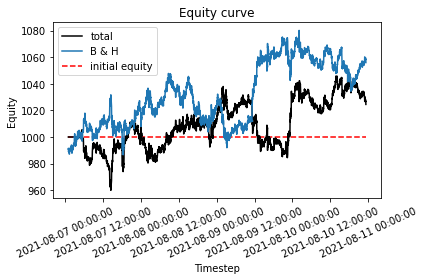

In [7]:
DATA_DIR = "data/"
SYMBOLS = ["BTCUSD", "ETHUSD", "LTCUSD"]
fees = 0.0
INIT_CAPITAL = 1000.0

START = -int(5e3)
STOP = -1
STEP = 1

STRAT_ID = 0

#initialize different components
#data loader
data_handler = HistoricCSVDataHandler(  data_dir = DATA_DIR,
                                    symbol_list=SYMBOLS
                                )

#execution order for orders
execution_engine = SimulatedExecutionEngine(fees)

#portfolio
portfolio = Portfolio(  bars = data_handler,
                        initial_capital = INIT_CAPITAL)

#scinet strategy
strategy = SCINET_Strategy( STRAT_ID, 
                            n_features = int(5 * len(SYMBOLS)),
                            threshold = 0.25,
                            model_weights = None)

#run backtest
backtester = Backtest(  data_handler = data_handler,
                        execution_engine = execution_engine,
                        portfolio = portfolio,
                        strategy = strategy,
                        START = START,
                        STOP = STOP, 
                        STEP = STEP)
backtester.run()